# Beamforming with Devito

This notebook uses the water tank model from the 01_modelling notebook and the snapshotting mechanism for visualization from the 01b_snapshotting notebook and introduces the beamforming technique for the source signals.

# Setup the problem

The velocity profile of our model changed. We have three domains: water in the middle domain with $1.5km/s$, a border region of glass with $5.6km/s$, and a region for an object on top of the bottom border with $3.24km/s$. 
We add multiple sources and a set of receivers along the top of the water. The distance between the sources is $0.25 mm$ and the peak frequency of the sources are $5MHz$ 

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


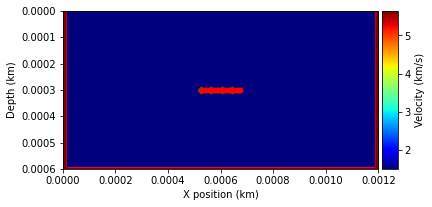

factor is 12
t_sub


Operator `Kernel` ran in 0.28 s


Saving snaps file
Dimensions: nz = 421, nx = 421


In [39]:
#NBVAL_IGNORE_OUTPUT
#%%flake8
%reset -f
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from examples.seismic import Receiver
from examples.seismic import Model, plot_velocity, TimeAxis
from devito import TimeFunction
from devito import Eq, solve
from devito import Operator
from devito import ConditionalDimension
from examples.seismic import WaveletSource

class SineSource(WaveletSource):
    @property
    def wavelet(self):
        t0 = self.t0 or 1 / self.f0
        a = self.a or 1
        r = (np.pi * self.f0 * (self.time_values - t0))
        wave = a * np.sin(r) + a*np.sin(3*(r+np.pi)/4)
        wave[np.searchsorted(self.time_values, 4*2/self.f0):] = 0
        return wave


# Set velocity model
nx = 401
nz = 401
nb = 10
shape = (nx, nz)
spacing = (.003, .0015) #30x30 cm
origin = (0., 0.)
glass = 5
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = 1.5 # v in distilled water 1496.7 m/s
v[:, -glass:] = 5.64 # v in glass 5640 m/s
v[:glass, :] = 5.64 # v in glass 5640 m/s
v[-glass:, :] = 5.64 # v in glass 5640 m/s
# Define an object's velocity profile
r = 15
a, b = shape[0] / 2, shape[1]- r - glass
y, x = np.ogrid[-a:shape[0]-a, -b:shape[1]-b]
#v[x*x + y*y <= r*r] = 5.64 #3.24

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = .2  # Simulation lasts tn milliseconds
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 16; # number of sources
nr = ns; # number of receivers
depth = .3
source_distance = 0.01 # 0.25 (0.00025 m)
src = SineSource(
    name='src',
    grid=model.grid,
    f0=f0,
    time_range=time_range,
    npoint=ns)

for i in range(ns):
    src.coordinates.data[i, :] = np.array(
        model.domain_size) * .5 + (i - (ns - 1) / 2) * source_distance
src.coordinates.data[:, -1] = depth

rec = Receiver(
    name='rec',
    grid=model.grid,
    npoint=nr,
    time_range=time_range) 
# rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], 
#                                           num=nr)
for i in range(nr):
     rec.coordinates.data[i, :] = np.array(
         model.domain_size) * .5 + (i - (nr - 1) / 2) * source_distance
rec.coordinates.data[:, 1] = depth

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

#Used for reshaping
vnx = nx+20 
vnz = nz+20

# Using params for snapshotting
nsnaps = 103            # desired number of equally spaced snaps
factor = round(nt / nsnaps)  # subsequent calculated factor
print(f"factor is {factor}")

time_subsampled = ConditionalDimension(
    't_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, 
                     space_order=2, save=nsnaps, time_dim=time_subsampled)
print(time_subsampled)

# Set symbolics for the wavefield object `u`, setting save on all time steps 
# (which can occupy a lot of memory), to later collect snapshots (naive method):

u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)

# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)
# The usual operator would be: op1 = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
op2 = Operator([stencil] + src_term + [Eq(usave, u)] + rec_term, subs=model.spacing_map)  # operator with snapshots
# Run the operator for `(nt-2)` time steps:
op2(time=nt - 2, dt=model.critical_dt)

print("Saving snaps file")
print("Dimensions: nz = {:d}, nx = {:d}".format(nz + 2 * nb, nx + 2 * nb))
filename = "snapshots/snaps.bin"
usave.data.tofile(filename)

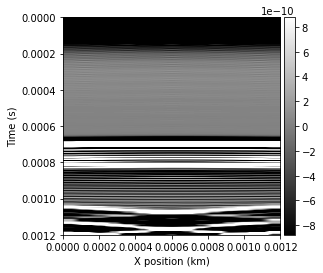

Data(8.76891e-09, dtype=float32)

In [46]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)
np.max(rec.data)

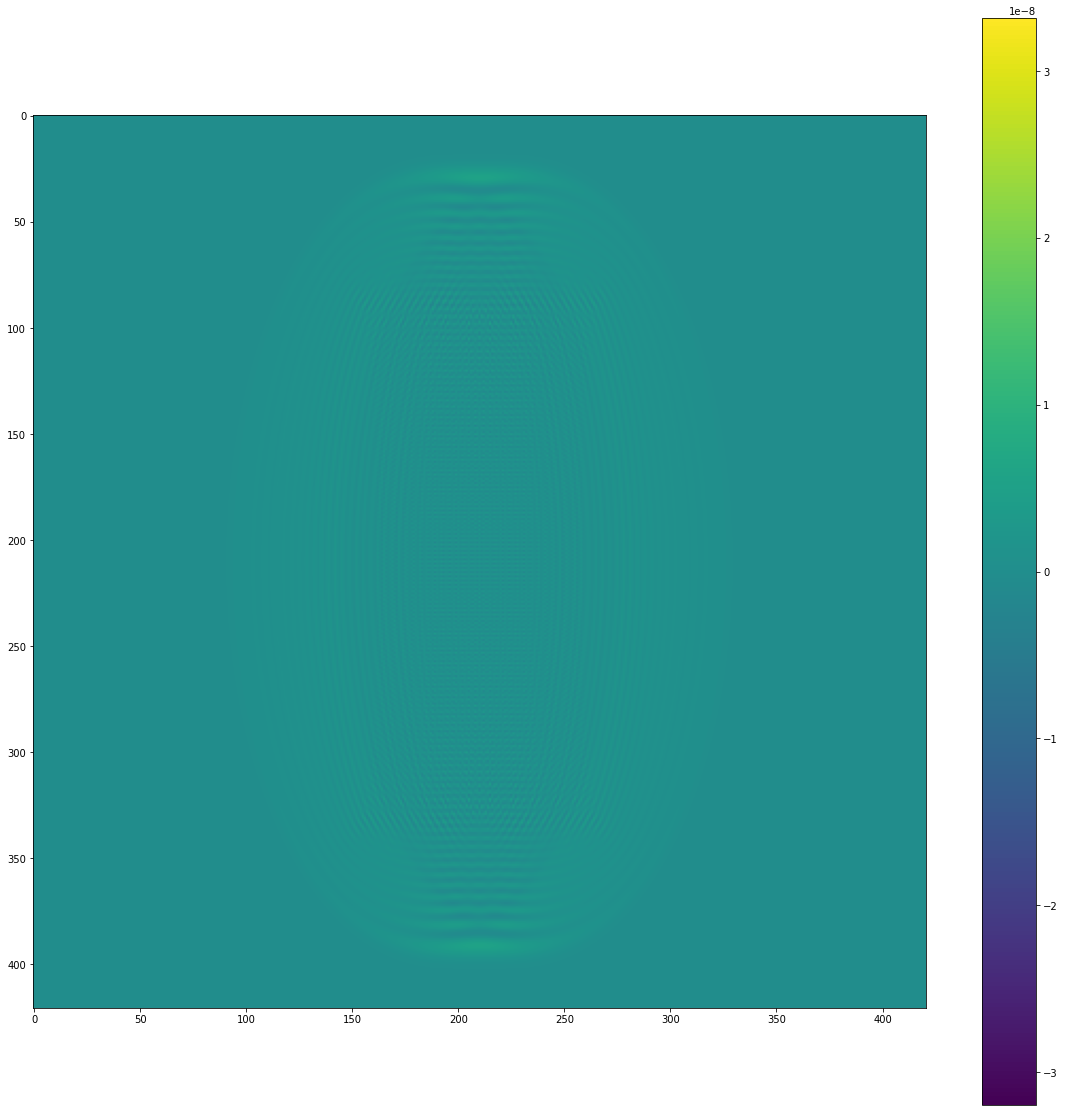

In [40]:
#NBVAL_IGNORE_OUTPUT
fobj = open("snapshots/snaps.bin", "rb")
snaps = np.fromfile(fobj, dtype=np.float32)
snaps = np.reshape(snaps, (nsnaps, vnx, vnz))
fobj.close()

plt.rcParams['figure.figsize'] = (20, 20)  # Increases figure size

imcnt = 1 # Image counter for plotting
plot_num = 20 # Number of images to plot
m = np.min(snaps)
ma = np.max(snaps)
for i in range(0, plot_num):
   # plt.subplot(1, plot_num, i+1);
   imcnt = imcnt + 1
   ind = i * int(nsnaps/plot_num)
   pos=plt.imshow(np.transpose(snaps[ind,:,:]), vmin=m, vmax=ma) #, cmap="seismic"
   filename = 'snapshots/tmp_%04d.png' % i
   plt.savefig(filename)
plt.colorbar(pos)
plt.show() 

-9.0971564e-10

In [19]:
#NBVAL_IGNORE_OUTPUT
#NBVAL_SKIP
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fobj = open("snapshots/snaps.bin", "rb")
snapsObj = np.fromfile(fobj, dtype=np.float32)
snapsObj = np.reshape(snapsObj, (nsnaps, vnx, vnz))
fobj.close()

fig, ax = plt.subplots()
matrice = ax.imshow(snapsObj[0, :, :].T, vmin=m, vmax=ma, cmap="seismic")
plt.colorbar(matrice)

plt.xlabel('x')
plt.ylabel('z')
plt.title('Modelling one shot over a 2-layer velocity model with Devito.')    

def update(i):
    matrice.set_array(snapsObj[i, :, :].T)
    return matrice,

# Animation
ani = animation.FuncAnimation(fig, update, frames=nsnaps, interval=50, blit=True)

plt.close(ani._fig)
HTML(ani.to_html5_video())